In [1]:
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [4]:
# Define filepath
filepath = '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/'
# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', '/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', '/Users/morganscafidi/Docu

In [6]:
# Open a single band
src = rasterio.open(files[1])
band_1 = src.read(1)

In [7]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


In [8]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [9]:
# Find format
src.driver

'GTiff'

In [10]:
# Find pixel size
src.transform[0]

30.0

In [11]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [12]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


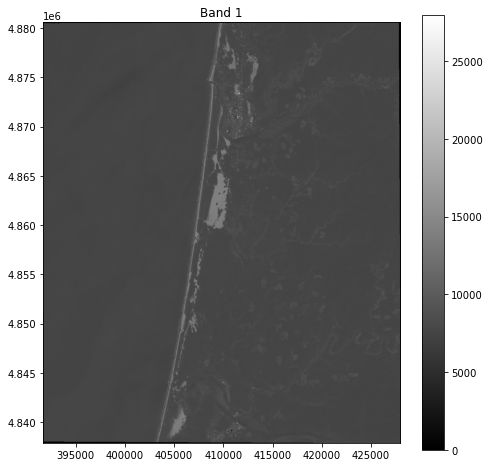

In [13]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

In [14]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [15]:
# Find total number of pixels in array
band_1.size

1717776

In [16]:
# Find maximum value in array
band_1.max()

27945

In [17]:
# Find datatype
band_1.dtype

dtype('uint16')

In [18]:
# Find maximum possible value in array
2**16

65536

In [19]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

In [20]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [21]:
all_bands.shape

(1422, 1208, 8)

In [22]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [24]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

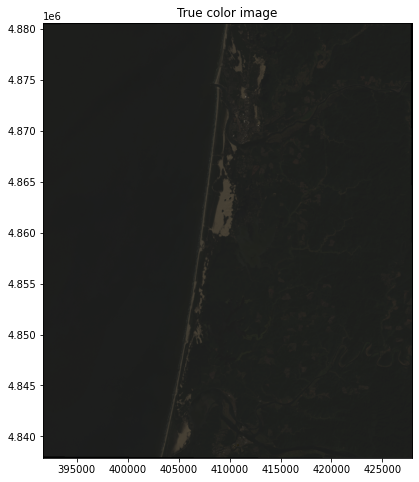

In [25]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

In [26]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

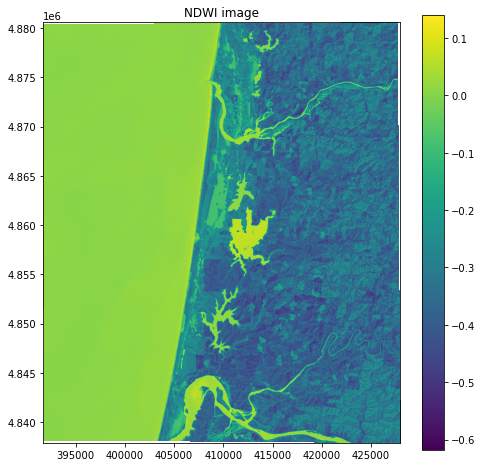

In [27]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [28]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [29]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

In [26]:
filepath

'/Users/morganscafidi/Documents/GitHub/geospatial-data-science/labs/lab4/data/'

In [30]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [31]:
# Question 3 a) an NDVI image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))
# Compute NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,5].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,5].astype(float) + all_bands[:,:,4].astype(float)))


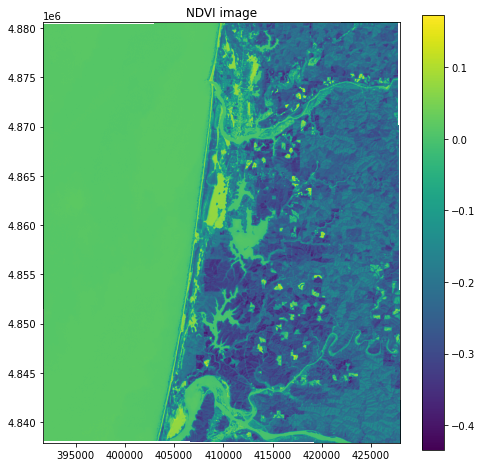

In [32]:
# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [33]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


In [34]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

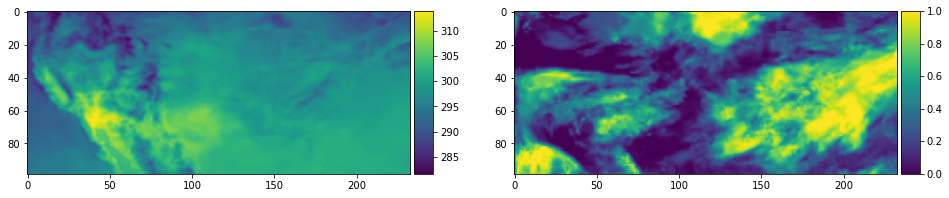

In [35]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [38]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=124.103142, method='nearest')

/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [39]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 74.29 %


In [41]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 64.02 F


Text(0, 0.5, 'Cloud cover (%)')

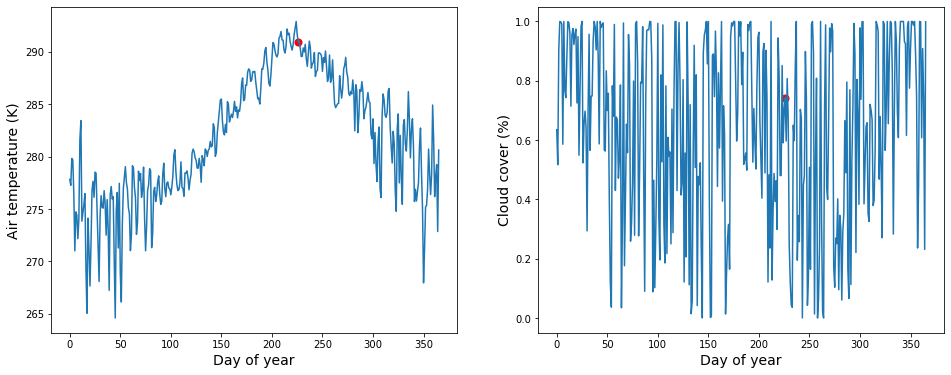

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)
ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

In [45]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 47.45 F


In [47]:
# Question 1
# a﴿ the air temperature ﴾in F﴿ and cloud cover ﴾in %﴿ in Florence, OR ﴾in 2020﴿ on January 31, 2020?
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on January 31, 2020 = %.2f %%' % (florence_weather['tcc'][30].values * 100))
fahrenheit = (florence_weather['t2m'][30].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on January 31, 2020 = %.2f F' % (fahrenheit))
# b﴿ the air temperature ﴾in F﴿ and cloud cover ﴾in %﴿ in Eugene, OR ﴾in 2020﴿ on February 15, 2020?
eugene_weather = xds_daily.sel(latitude=44.0521, longitude=-123.0868, method='nearest')
print('Cloud cover in Eugene on February 15, 2020 = %.2f %%' % (eugene_weather['tcc'][45].values * 100))
fahrenheit = (eugene_weather['t2m'][45].values - 273.15) * 9/5 + 32
print('Air temperature in Eugene on February 15, 2020 = %.2f F' % (fahrenheit))

Cloud cover in Florence on January 31, 2020 = 29.38 %
Air temperature in Florence on January 31, 2020 = 34.14 F
Cloud cover in Eugene on February 15, 2020 = 99.99 %
Air temperature in Eugene on February 15, 2020 = 42.00 F


/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/envs/lab4/lib/python3.8/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [49]:
# Question 2
# a﴿ Highest average air temperature ﴾i.e. hottest place﴿
#max_average_temp = ﴾xds_daily['t2m'].mean﴾﴿ - 273.15﴿ * 9/5 + 32
#print﴾'Highest average air temp. in the U.S. is  in 2020 = %.2f F' % ﴾mean_temp﴿﴿
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)
print('The highest average air temperature is in Hacienda Los Tesoros, Sonora, Mexico')
# b﴿ Lowest average air temperature ﴾i.e. coldest place﴿
min_value = np.mean(xds_daily['t2m'], axis=0).argmin()
index = np.unravel_index(min_value, np.mean(xds_daily['t2m'], axis=0).shape)
np.mean(xds_daily['t2m'], axis=0)[index]
print('The lowest average air temperature is in Wyoming, at the Latitude Longitude 43.99, -109.8')
# c﴿ Highest average cloudiness ﴾i.e. cloudiest place﴿
# HINT use argmax﴾﴿ or argmin﴾﴿
max_cc = np.mean(xds_daily['tcc'], axis=0).argmax()
index = np.unravel_index(max_cc, np.mean(xds_daily['tcc'], axis=0).shape)
maxccloc=np.mean(xds_daily['tcc'], axis=0)[index]
print('The highest average cloudiness is in Sproat Lake, British Columbia, Canada')
# d﴿ Lowest average cloudiest ﴾i.e. least cloudy place﴿
min_cc = np.mean(xds_daily['tcc'], axis=0).argmin()
index = np.unravel_index(min_cc, np.mean(xds_daily['tcc'], axis=0).shape)
minccloc=np.mean(xds_daily['tcc'], axis=0)[index]
print('The lowest average cloudiness is in the Gulf of Baja California at the Latitude Longitude 31.49, -114.8')
# e﴿ Place with highest range in daily air temperature
daily_max = np.max(xds_daily['t2m'],axis=0)
daily_max
daily_min = np.min(xds_daily['t2m'],axis=0)
daily_min
temprange = (daily_max - daily_min)
temprange
max_range = temprange.argmax()
max_range
max_range_idx = np.unravel_index(max_range,xds_daily['t2m'].shape)
print(max_range_idx)
daily_max[1,210]
print('The maximum range in daily air temperature is in Girardville, MariaChapdelaine, QC, Canada')
# f﴿ Place with the absolute coldest temperature on a single day
min_value = np.min(xds_daily['t2m'], axis=0).argmin()
index = np.unravel_index(min_value, np.min(xds_daily['t2m'], axis=0).shape)
np.min(xds_daily['t2m'], axis=0)[index]
print('The absolute coldest temperature is in Eagle Creek Colony, Montana')

The highest average air temperature is in Hacienda Los Tesoros, Sonora, Mexico
The lowest average air temperature is in Wyoming, at the Latitude Longitude 43.99, -109.8
The highest average cloudiness is in Sproat Lake, British Columbia, Canada
The lowest average cloudiness is in the Gulf of Baja California at the Latitude Longitude 31.49, -114.8
(0, 1, 210)
The maximum range in daily air temperature is in Girardville, MariaChapdelaine, QC, Canada
The absolute coldest temperature is in Eagle Creek Colony, Montana


In [50]:
daily_max[1,210]

<xarray.DataArray 't2m' ()>
array(303.31824, dtype=float32)
Coordinates:
    longitude  float32 -72.5
    latitude   float32 48.99

In [51]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)
# Convert from list of arrays to n­dimensional array
all_bands = np.dstack(list_bands)

In [53]:
# Question 3 a﴿ an NDVI image ﴾i.e. ﴾Band 5 - Band 4﴿ / ﴾Band 5 + Band 4﴿﴿
# Compute NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

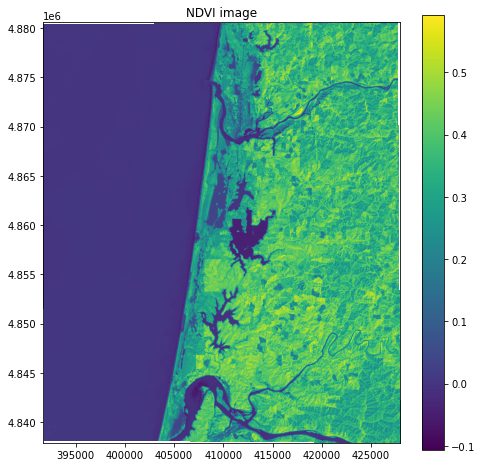

In [54]:
# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [55]:
# b﴿ a color infrared composite ﴾i.e. bands 5, 4, 3﴿
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)
# Convert from list of arrays to ndimensional array
all_bands = np.dstack(list_bands)

In [56]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [57]:
# Produce a new array by stacking the RGB bands
color_infared_composite = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

In [58]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


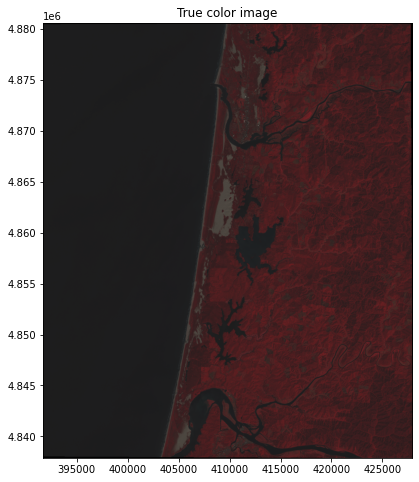

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(color_infared_composite, extent=full_extent)
ax.set_title("True color image")
plt.show()